# Import Libraries and Load Data

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics._scorer import make_scorer
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from scipy.stats import randint

from utils import SpaceTimeSplits
from metrics import get_metrics

pd.options.mode.chained_assignment = None   # to disable chained assignment warning (by default, this is "warn")

In [2]:
# From the validation Actual and Prediction columns
target_metrics = {
    'rmse': 30.874488274822923,
    'mae': 10.108542659950823,
    'mape': 0.5554461311204274,
    'r2': 0.8229691722882178,
    'bias': 5.260115649343916,
    'pct_bias': -0.2124630453389412,
    'smape': 0.4586837552555118
}

In [3]:
TO_NORM_FEATS = True # set to True to normalize features
TO_NORM_LABELS = False # set to True to normalize labels
IS_PRED_EXP = False  # Set to True to directly predict TSS as np.exp(value). otherwise, estimate the ln of the actual TSS value and just modify for measuring metrics
GRIDSEARCH_CV_SCORING = 'neg_root_mean_squared_error'
"""Other options for grid cv scoring:
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'r2',
 """

CV_FOLDS = 3

In [4]:
# train_data = pd.read_csv("../data/train_clean_v1.csv")
train_data = pd.read_csv("../data/train_raw.csv")
val_data = pd.read_csv("../data/validation_v1.csv")

/var/folders/1l/36wkr52s0qg1mbnfl6h1v30m0000gn/T/ipykernel_53856/228957105.py:2: DtypeWarning: Columns (176,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../data/train_raw.csv")


## Clean and normalize data

In [5]:
label = "value"
# feats = [x for x in train_data.columns if x!=label]
feats = ['nir', 'R.BS', 'swir2', 'N_R', 'BG', 'swir1', 'RG', 'bright', 'GR']
group_names = ["time_group", "space_group"]

In [6]:
logger.debug(f"feats: {feats}")
logger.debug(f"label: {label}")

2022-10-13 13:23:06.416 | DEBUG    | __main__:<cell line: 1>:1 - feats: ['nir', 'R.BS', 'swir2', 'N_R', 'BG', 'swir1', 'RG', 'bright', 'GR']
2022-10-13 13:23:06.418 | DEBUG    | __main__:<cell line: 2>:2 - label: value


In [7]:
x, y, groups = train_data[feats], train_data[label], train_data[group_names]
x_test, y_test = val_data[feats], val_data[label]

if IS_PRED_EXP:
    y = np.exp(y)

In [8]:
x.describe()

,nir,R.BS,swir2,N_R,BG,swir1,RG,bright,GR
count,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000
mean,406.625089,0.725763,122.661092,-28.681465,0.833156,173.137510,0.808549,0.023701,1.295260
std,254.664557,0.219667,109.282147,177.936479,0.154766,141.121048,0.166554,0.011047,0.302089
min,2.534454,0.144302,2.000000,-2095.398686,0.057631,2.000000,0.228465,0.003515,0.554937
25%,217.000000,0.580557,48.000000,-120.000000,0.726007,72.000000,0.698592,0.015900,1.093750
50%,343.837277,0.679642,87.000000,-29.072158,0.817006,130.373015,0.802954,0.021755,1.245402
75%,541.000000,0.826498,159.000000,68.576429,0.923061,228.000000,0.914286,0.029093,1.431451
max,2322.000000,2.877701,853.000000,835.000000,2.528471,1010.000000,1.802007,0.145566,4.377046


In [9]:
def normalize_train_feat(df, col_name):
    mu = np.mean(df[col_name])
    sigma = np.var(df[col_name])**0.5
    return (df[col_name]-mu)/sigma, mu, sigma

def normalize_test_feat(df, col_name, mu, sigma):
    return (df[col_name]-mu)/sigma

if TO_NORM_FEATS:
    norm_params = {x:None for x in feats}
    for col_name in feats:
        # Normalize train features
        col_val, mu, sigma = normalize_train_feat(x, col_name)
        x.loc[:, (col_name)] = col_val
        norm_params[col_name] = [mu, sigma]

        # Normalize test features
        col_val = normalize_test_feat(x_test, col_name, mu, sigma)
        x_test.loc[:, (col_name)] = col_val
if TO_NORM_LABELS:
    col_val, label_mu, label_sigma = normalize_train_feat(train_data, label)
    y = col_val

In [10]:
x.describe()

,nir,R.BS,swir2,N_R,BG,swir1,RG,bright,GR
count,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04,2.893300e+04
mean,1.964657e-16,-3.497089e-16,-1.041268e-16,2.357588e-17,-4.224012e-16,-1.178794e-16,8.978482e-16,-1.060915e-16,2.730873e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.586784e+00,-2.647058e+00,-1.104144e+00,-1.161512e+01,-5.011054e+00,-1.212721e+00,-3.482913e+00,-1.827313e+00,-2.450723e+00
25%,-7.446202e-01,-6.610375e-01,-6.832075e-01,-5.132175e-01,-6.923449e-01,-7.166844e-01,-6.602007e-01,-7.061898e-01,-6.670680e-01
50%,-2.465553e-01,-2.099630e-01,-3.263269e-01,-2.195726e-03,-1.043512e-01,-3.030394e-01,-3.359657e-02,-1.761720e-01,-1.650485e-01
75%,5.276637e-01,4.585900e-01,3.325295e-01,5.465972e-01,5.809218e-01,3.887686e-01,6.348580e-01,4.880842e-01,4.508378e-01
max,7.521298e+00,9.796527e+00,6.683173e+00,4.853959e+00,1.095427e+01,5.930206e+00,5.964869e+00,1.103138e+01,1.020175e+01


In [11]:
train_data.describe()["value"]

count    28933.000000
mean         2.542637
std          1.045167
min         -2.197235
25%          1.856298
50%          2.484907
75%          3.178054
max          9.296518
Name: value, dtype: float64

# Train XGB Models

## Define Custom Scorers for CV

In [12]:

def adjusted_rmse(y_true, y_pred, **kwargs):
    # print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    if IS_PRED_EXP:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    else:
        rmse = np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))
    # print(f"rmse: {rmse}")
    return rmse

def adjusted_mae(y_true, y_pred, **kwargs):
    # print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    if IS_PRED_EXP:
        mae = mean_absolute_error(y_true, y_pred)
    else:
        mae = mean_absolute_error(np.exp(y_true), np.exp(y_pred))
    # print(f"mae: {mae}")
    return mae

def adjusted_mape(y_true, y_pred, **kwargs):
    # print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    if IS_PRED_EXP:
        mape = mean_absolute_percentage_error(y_true, y_pred)
    else:
        mape = mean_absolute_percentage_error(np.exp(y_true), np.exp(y_pred))
    # print(f"mape: {mape}")
    return mape


def adjusted_r2(y_true, y_pred, **kwargs):
    # print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    if IS_PRED_EXP:
        r2 = r2_score(y_true, y_pred)
    else:
        r2 = r2_score(np.exp(y_true), np.exp(y_pred))
    # print(f"r2: {r2}")
    return r2

rmse_scorer = make_scorer(adjusted_rmse, greater_is_better=False)
mae_scorer = make_scorer(adjusted_mae, greater_is_better=False)
r2_scorer = make_scorer(adjusted_r2, greater_is_better=True)
mape_scorer = make_scorer(adjusted_mape, greater_is_better=False)

## Train Model with Similar Params as R Model

In [13]:

init_param = {
 'n_estimators': 100, # num rounds
 'alpha': 0,
 'lambda': 1,
 'eta': 0.3,    # learning_rate
 'objective':'reg:squarederror',
 'booster': "gblinear",
 "updater": "coord_descent",
}


xgb_reg = xgb.XGBRegressor(**init_param)
xgb_reg.fit(x,y)
train_pred = xgb_reg.predict(x)

if IS_PRED_EXP:
    train_metrics = get_metrics(y, train_pred)
else:
    train_metrics = get_metrics(np.exp(y), np.exp(train_pred))
# print(f"train_metrics: {train_metrics}")

test_pred = xgb_reg.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test,  np.round(np.exp(test_pred),2))

# Display metrics
train_metrics["source"] = "train set"
test_metrics["source"] = "test set"
target_metrics["source"] = "test set target"
ds = [train_metrics, test_metrics, target_metrics]
pd.DataFrame(ds)

,rmse,mae,mape,r2,bias,pct_bias,smape,source
0,117.546048,15.814622,0.824805,0.043729,10.161883,-0.404225,0.600158,train set
1,67.977775,15.586608,0.836105,0.141810,9.902953,-0.414352,0.600498,test set
2,30.874488,10.108543,0.555446,0.822969,5.260116,-0.212463,0.458684,test set target


# Current Best XGB Model

In [32]:
init_param = {
 'alpha': 0.01,
 'lambda': 1,
 'eta': 0.3,    # learning_rate
 'n_estimators': 50, # num rounds
 'max_depth': 5,
 'objective':'reg:squarederror',
 "booster": "gbtree",
}

xgb_reg = xgb.XGBRegressor(**init_param)
xgb_reg.fit(x,y)
train_pred = xgb_reg.predict(x)


model = xgb.XGBRegressor(**init_param)

st_cv = SpaceTimeSplits(n_splits=CV_FOLDS)
custom_splitter = st_cv.split(
    x,
    y,
    groups=groups
)
# and then conduct the cross validation with the same folds as before
scoring = {
    'rmse':rmse_scorer,
    'mae':mae_scorer,
    'r2':r2_scorer,
    'mape':mape_scorer,

}
multi_score = cross_validate(xgb_reg, x, y, cv=custom_splitter, scoring=scoring, n_jobs=-1)
print(f"multi_score: {multi_score}")

if IS_PRED_EXP:
    train_metrics = get_metrics(y, train_pred)
else:
    train_metrics = get_metrics(np.exp(y), np.exp(train_pred))

test_pred = xgb_reg.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test,  np.round(np.exp(test_pred),2))

# Display metrics
train_metrics["source"] = "train set"
test_metrics["source"] = "test set"
target_metrics["source"] = "test set target"
ds = [train_metrics, test_metrics, target_metrics]
pd.DataFrame(ds)

multi_score: {'fit_time': array([1.64113307, 1.90127683, 1.92168117]), 'score_time': array([0.00843596, 0.00390291, 0.00433993]), 'test_rmse': array([-22.44456817, -38.05622588, -29.86181897]), 'test_mae': array([-12.84932183, -16.22882556, -14.49516155]), 'test_r2': array([0.13382471, 0.64286406, 0.41693006]), 'test_mape': array([-0.60123984, -0.93209807, -0.57206089])}


,rmse,mae,mape,r2,bias,pct_bias,smape,source
0,47.017754,12.073983,0.660444,0.847001,5.891952,-0.282268,0.521248,train set
1,38.448486,13.102054,0.723427,0.725459,5.768493,-0.326757,0.551398,test set
2,30.874488,10.108543,0.555446,0.822969,5.260116,-0.212463,0.458684,test set target


## Plot predictions vs actual TSS values

(0.4964147785050765, 4351.200031765194)

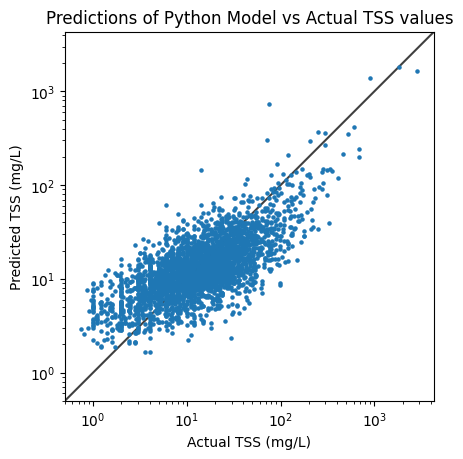

In [15]:
ax = plt.gca()
plt.scatter(y_test, np.exp(test_pred), s=5)
# plt.xlim(0,3000)
plt.ylabel("Predicted TSS (mg/L)")
plt.xlabel("Actual TSS (mg/L)")
plt.title("Predictions of Python Model vs Actual TSS values")
ax.set_xscale("log")
ax.set_yscale("log")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

(0.4964147785050765, 4351.200031765194)

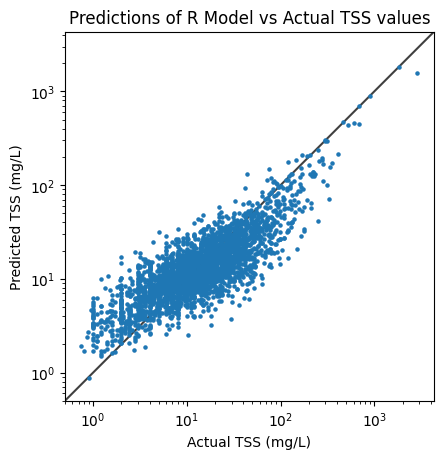

In [16]:
r_tss_vals = val_data["Predicted"].values
ax = plt.gca()
plt.scatter(y_test, r_tss_vals, s=5)
# plt.xlim(0,3000)
plt.ylabel("Predicted TSS (mg/L)")
plt.xlabel("Actual TSS (mg/L)")
plt.title("Predictions of R Model vs Actual TSS values")
ax.set_xscale("log")
ax.set_yscale("log")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

(0.6044898962962955, 2642.3591441039603)

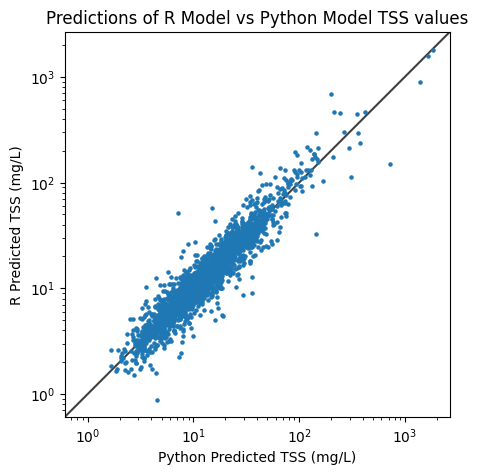

In [33]:
r_tss_vals = val_data["Predicted"].values
ax = plt.gca()
plt.scatter(np.exp(test_pred), r_tss_vals, s=5)
# plt.xlim(0,3000)
plt.ylabel("R Predicted TSS (mg/L)")
plt.xlabel("Python Predicted TSS (mg/L)")
plt.title("Predictions of R Model vs Python Model TSS values")
ax.set_xscale("log")
ax.set_yscale("log")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# [WIP] Trying out other models

## Grid Search Hyperparams of XGB

In [17]:

param2 = {
 'alpha': [0,0.01],    #[0, 0.001, 0.005, 0.01, 0.05]
 'lambda': [0,1],
 'eta': [0.1,0.2],
 'n_estimators': [20,40], # num rounds
 'max_depth': [3,4,5]
}
st_cv = SpaceTimeSplits(n_splits=CV_FOLDS)
custom_splitter = st_cv.split(
    x,
    y,
    groups=groups)
# param = {'max_depth':2, 'eta':1, 'objective':'reg:squarederror'}


gsearch1 = GridSearchCV(
    estimator = xgb.XGBRegressor(**init_param), 
    param_grid = param2,
    # scoring='r2',
    scoring=GRIDSEARCH_CV_SCORING, 
    n_jobs=4,
    # iid=False,
    cv=custom_splitter,
    verbose=1,
)
gsearch1.fit(x,y, groups=groups)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=<generator object SpaceTimeSplits.split at 0x141321dd0>,
             estimator=XGBRegressor(alpha=0.01, base_score=None,
                                    booster='gbtree', callbacks=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.3,
                                    eval_metric=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=50,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, ...),
             n_jobs=4,
             param_grid={'alpha': [0, 0.01], 'eta': [0.1, 0.2],
                         'lambda': [0, 1], 'max_depth': [3, 4, 5],
                         'n_estimators': [20, 40]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [18]:
best_params = gsearch1.best_params_
best_score = gsearch1.best_score_
logger.info(f"best_params: {best_params}, best_score: {best_score}")

best_model = gsearch1.best_estimator_
# best_model = xgb.XGBRegressor(**best_params)
best_model.fit(x,y)

# Predict on test set
test_pred = best_model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))

# Display metrics
test_metrics["source"] = "test set"
target_metrics["source"] = "test set target"
ds = [test_metrics, target_metrics]
pd.DataFrame(ds)

2022-10-13 13:23:47.646 | INFO     | __main__:<cell line: 3>:3 - best_params: {'alpha': 0.01, 'eta': 0.1, 'lambda': 1, 'max_depth': 5, 'n_estimators': 40}, best_score: -0.7512170305435809


,rmse,mae,mape,r2,bias,pct_bias,smape,source
0,49.002382,13.520952,0.705132,0.554052,7.501515,-0.289302,0.555478,test set
1,30.874488,10.108543,0.555446,0.822969,5.260116,-0.212463,0.458684,test set target


### Plot XGB Model and Feat Importance

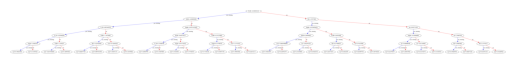

In [19]:
xgb.plot_tree(best_model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

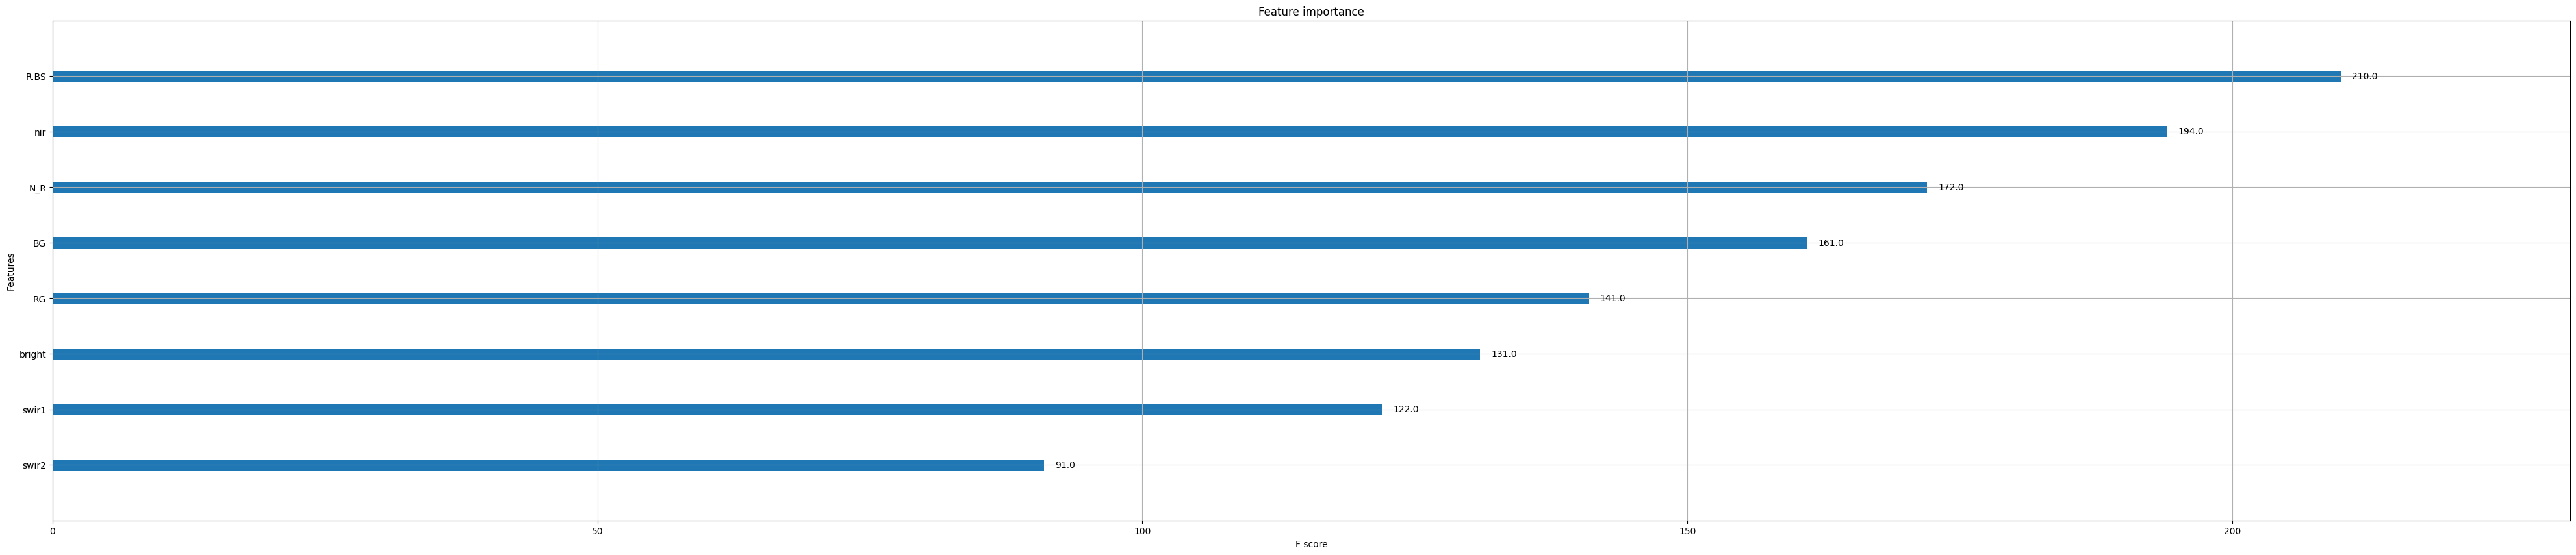

In [20]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Use RandomizedSearchCV for XGB Tuning

In [21]:
param_grid_rand={
    'learning_rate': np.logspace(-5, 0, 100),
    'max_depth':  randint(2,20),
    'n_estimators': randint(100,2000),
    'alpha': np.logspace(0, 3, 20),
    'lambda': np.logspace(0, 3, 20),
}
st_cv = SpaceTimeSplits(n_splits=CV_FOLDS)
custom_splitter = st_cv.split(
    x,
    y,
    groups=groups)


rsearch = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(**init_param), 
    param_distributions = param_grid_rand,
    # scoring='r2',
    scoring=GRIDSEARCH_CV_SCORING, 
    n_jobs=4,
    # n_iter=50,
    n_iter=10,
    # iid=False,
    cv=custom_splitter,
    verbose=1,
)
rsearch.fit(x,y, groups=groups)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=<generator object SpaceTimeSplits.split at 0x14157e660>,
                   estimator=XGBRegressor(alpha=0.01, base_score=None,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.3,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance...
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14163a400>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14163a730>},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [22]:
rbest_params = rsearch.best_params_
rbest_score = rsearch.best_score_
logger.info(f"best_params: {best_params}, best_score: {best_score}")

rbest_model = rsearch.best_estimator_
# best_model = xgb.XGBRegressor(**best_params)
rbest_model.fit(x,y)

# Predict on test set
test_pred = rbest_model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))

# Display metrics
test_metrics["source"] = "test set"
target_metrics["source"] = "test set target"
ds = [test_metrics, target_metrics]
pd.DataFrame(ds)

2022-10-13 13:29:10.549 | INFO     | __main__:<cell line: 3>:3 - best_params: {'alpha': 0.01, 'eta': 0.1, 'lambda': 1, 'max_depth': 5, 'n_estimators': 40}, best_score: -0.7512170305435809


,rmse,mae,mape,r2,bias,pct_bias,smape,source
0,38.481102,12.944995,0.720644,0.724993,6.109380,-0.326229,0.550031,test set
1,30.874488,10.108543,0.555446,0.822969,5.260116,-0.212463,0.458684,test set target


## Using Hyperopt for Model Searching

In [23]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score
# from lightgbm.sklearn import LGBMRegressor

def gb_mse_cv(params, x=x, y=y, random_state=0):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'eta': params['eta'],
              'lambda': params['lambda'],
              'alpha': params['alpha'],
            }
    
    # we use this params to create a new LGBM Regressor
    # model = LGBMRegressor(random_state=random_state, **params)
    model = xgb.XGBRegressor(**params)
    
    st_cv = SpaceTimeSplits(n_splits=CV_FOLDS)
    custom_splitter = st_cv.split(
        x,
        y,
        groups=groups
    )
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, x, y, cv=custom_splitter, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [24]:
n_iter = 50
random_state=0
# possible values of parameters
# space={
#     'n_estimators': hp.quniform('n_estimators', 20, 2000, 1),
#     'max_depth' : hp.quniform('max_depth', 2, 20, 1),
#     'learning_rate': hp.loguniform('learning_rate', -5, 0)
# }

space = {
    'alpha': hp.loguniform('alpha', 0, 3),
    'lambda': hp.loguniform('lambda', 0, 3),
    'eta': hp.loguniform('eta', -5, 5),
    'n_estimators': hp.quniform('n_estimators', 20, 2000, 1),
    'max_depth' : hp.quniform('max_depth', 2, 20, 1),
}

# trials will contain logging information
trials = Trials()
"""
best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
        #   rstate=np.random.default_rng(0) # fixing random state for the reproducibility
)

model = xgb.XGBRegressor(**best)
model.fit(x,y)
test_preds = model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
    tpe_test_score=mean_squared_error(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))
    tpe_test_score=mean_squared_error(y_test, np.round(np.exp(test_pred),2))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))
"""
print()

In [25]:
# example of hyperopt-sklearn for the housing regression dataset
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

# define search
model = HyperoptEstimator(regressor=any_regressor('reg'),
    preprocessing=any_preprocessing('pre'),
    loss_fn=mean_absolute_error,
    algo=tpe.suggest,
    max_evals=10,
    trial_timeout=30,
)
# perform the search
model.fit(x, y)
# summarize performance
# mae = model.score(x_test, y_test)
test_pred = model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))
# print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

100%|██████████| 10/10 [00:08<00:00,  8.54s/trial, best loss: 0.5824385675854972]
{'learner': GradientBoostingRegressor(alpha=0.8595753728403898, criterion='squared_error',
                          learning_rate=0.15234707837387043, loss='huber',
                          min_samples_leaf=48, n_estimators=54, random_state=2,
                          verbose=False), 'preprocs': (StandardScaler(with_mean=False),), 'ex_preprocs': ()}


/Users/rangel/miniconda3/envs/aist-ssc/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [26]:
hyper_model = model.best_model()
h_model = hyper_model["learner"]
h_model.fit(x,y)


test_pred = h_model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))
# print("MAE: %.3f" % mae)
# summarize the best model
print(test_metrics)

{'rmse': 52.02671575362783, 'mae': 13.653675765692808, 'mape': 0.7245183365211549, 'r2': 0.4973077538735483, 'bias': 6.839828500401183, 'pct_bias': -0.3239505984633853, 'smape': 0.5552289995400348}


In [27]:
print(TO_NORM_LABELS)
print(f"test_metrics: {test_metrics}")
print(f"target_metrics: {target_metrics}")

False
test_metrics: {'rmse': 52.02671575362783, 'mae': 13.653675765692808, 'mape': 0.7245183365211549, 'r2': 0.4973077538735483, 'bias': 6.839828500401183, 'pct_bias': -0.3239505984633853, 'smape': 0.5552289995400348}
target_metrics: {'rmse': 30.874488274822923, 'mae': 10.108542659950823, 'mape': 0.5554461311204274, 'r2': 0.8229691722882178, 'bias': 5.260115649343916, 'pct_bias': -0.2124630453389412, 'smape': 0.4586837552555118, 'source': 'test set target'}


## Train other types of models

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor

from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

In [29]:
init_rf_params = {
    "criterion": "squared_error",
    "max_depth": 3,
    "min_samples_split": 4,
    "min_samples_leaf": 1,
}
model_rf = RandomForestRegressor(**init_rf_params)

init_lgb_params = {
    "boosting_type": "gbt",
    "learning_rate": 0.1,
    "n_estimators": 100,
    "objective": "regression",
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
}
model_lgb = LGBMRegressor(**init_lgb_params)

init_mlp_params = {
    "activation": "tanh",
    "solver": "sgd",
    "alpha": 0.0001,
    "learning_rate": "adaptive",
    "max_iter": 200,
    "momentum": 0.9,    #bet 0 and 1 for sgd
    "early_stopping": True,
}
model_mlp = MLPRegressor(**init_mlp_params)

In [30]:
EPS=1e-16
search_space = hp.choice('reg_type', [
    {
        'type': 'xgb',
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
        'max_depth':  hp.quniform('max_depth', 2, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
        'alpha': hp.loguniform('alpha', np.log(0.0001), np.log(2.0)),
        'lambda': hp.loguniform('lambda', np.log(0.0001), np.log(2.0)),
    },
    {
        'type': 'rf',
        'max_depth': hp.quniform('max_depth_rf', 2, 20, 1),
        'criterion': hp.choice('criterion', ["squared_error", "absolute_error"]),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
    },
    {
        'type': 'lgb',
        'boosting_type': hp.choice('boosting_type', ["gbdt", "dart","goss"]),
        'learning_rate': hp.loguniform('learning_rate_lgb', np.log(EPS), np.log(1.0)),
        'n_estimators': hp.quniform('n_estimators_lgb', 10, 200, 10),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(2.0)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(2.0)),
        # 'solver': hp.choice('solver', ['liblinear', 'lbfgs'])
    },
    {
        'type': 'mlp',
        'alpha': hp.loguniform('alpha_mlp', np.log(0.0001), np.log(2.0)),
        "learning_rate": hp.choice("learning_rate_mlp",["constant", "invscaling", "adaptive"]),
        "max_iter": hp.quniform('max_iter', 50, 200, 10),
        "momentum": hp.loguniform('momentum', np.log(0.1), np.log(0.99)),
    },
])

In [ ]:
int_params = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "max_iter"]
def gb_mse_cv(params, x=x, y=y, random_state=0):
    print(params)
    reg_type = params["type"]
    del params["type"]
    for c in int_params:
        if c in params:
            params[c] = int(params[c])

    if reg_type == "xgb":
        model = xgb.XGBRegressor(
            **params,
            # objective='reg:squarederror',
        )
    elif reg_type == "rf":
        model = RandomForestRegressor(
            **params,
            # criterion="squared_error",
        )
    elif reg_type == "lgb":
        model = LGBMRegressor(
            **params,
            # objective="regression",
        )
    elif reg_type == "mlp":
        model = MLPRegressor(
            **params,
            activation="tanh",
            solver="sgd",
            early_stopping=True,
        )
    
    
    st_cv = SpaceTimeSplits(n_splits=CV_FOLDS)
    custom_splitter = st_cv.split(
        x,
        y,
        groups=groups
    )
    # and then conduct the cross validation with the same folds as before
    # NOTE: fmin will try to minimize the score and since we want lower MSE, we negate the -MSE to get MSE
    # effectively, fmin will try to minimize mse
    score = -cross_val_score(model, x.values, y, cv=custom_splitter, scoring="neg_mean_squared_error", n_jobs=1, error_score='raise')
    score = score.mean()

    return score

reg_model_trials = Trials()
best_result = fmin(
    fn=gb_mse_cv, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=reg_model_trials,
    
)

In [ ]:
best_result

{'criterion': 0,
 'max_depth_rf': 8.0,
 'min_samples_leaf': 15.0,
 'min_samples_split': 15.0,
 'reg_type': 1}

In [ ]:
# all_hyper_model = best_result.best_model()
all_h_model = RandomForestRegressor(
            # **best_result,
            criterion="squared_error",
            max_depth= 8,
            min_samples_leaf= 15,
            min_samples_split= 15,
            #  reg_type= 1
        )
all_h_model.fit(x,y)


test_pred = all_h_model.predict(x_test)
if TO_NORM_LABELS:
    # reverse normalization
    test_pred = (test_pred*label_sigma) + label_mu
if IS_PRED_EXP:
    test_metrics = get_metrics(y_test, test_pred)
else:
    test_metrics = get_metrics(y_test, np.round(np.exp(test_pred),2))
# print("MAE: %.3f" % mae)
# summarize the best model
print(test_metrics)

2022-10-13 08:34:18.302 | DEBUG    | metrics:get_metrics:28 - rmse: 49.61778209937091


{'rmse': 49.61778209937091, 'mae': 13.497202065101463, 'mape': 0.7302418795467275, 'r2': 0.5427812219450256, 'bias': 6.459109546152816, 'pct_bias': -0.33290064024761684, 'smape': 0.5558463430257409}


In [ ]:
reg_model_trials.best_trial

{'state': 2,
 'tid': 27,
 'spec': None,
 'result': {'loss': 0.47156340926184453, 'status': 'ok'},
 'misc': {'tid': 27,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'alpha': [],
   'alpha_mlp': [],
   'boosting_type': [],
   'criterion': [27],
   'lambda': [],
   'learning_rate': [],
   'learning_rate_lgb': [],
   'learning_rate_mlp': [],
   'max_depth': [],
   'max_depth_rf': [27],
   'max_iter': [],
   'min_samples_leaf': [27],
   'min_samples_split': [27],
   'momentum': [],
   'n_estimators': [],
   'n_estimators_lgb': [],
   'reg_alpha': [],
   'reg_lambda': [],
   'reg_type': [27]},
  'vals': {'alpha': [],
   'alpha_mlp': [],
   'boosting_type': [],
   'criterion': [0],
   'lambda': [],
   'learning_rate': [],
   'learning_rate_lgb': [],
   'learning_rate_mlp': [],
   'max_depth': [],
   'max_depth_rf': [8.0],
   'max_iter': [],
   'min_samples_leaf': [15.0],
   'min_samples_split': [15.0],
   'momentum': [],
   'n_estimators': [],
   'n_estimat